##### Copyright 2021 The TensorFlow Authors.

In [132]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Generate music with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/audio/music_generation"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/music_generation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/audio/music_generation.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/audio/music_generation.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial shows you how to generate musical notes using a simple recurrent neural network (RNN). You will train a model using a collection of piano MIDI files from the [MAESTRO dataset](https://magenta.tensorflow.org/datasets/maestro). Given a sequence of notes, your model will learn to predict the next note in the sequence. You can generate longer sequences of notes by calling the model repeatedly.

This tutorial contains complete code to parse and create MIDI files. You can learn more about how RNNs work by visiting the [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation) tutorial.

## Setup

This tutorial uses the [`pretty_midi`](https://github.com/craffel/pretty-midi) library to create and parse MIDI files, and [`pyfluidsynth`](https://github.com/nwhitehead/pyfluidsynth) for generating audio playback in Colab.

In [133]:
# !source music/bin/activate

In [134]:
# !sudo apt install -y fluidsynth

In [135]:
# !pip install --upgrade pyfluidsynth

In [136]:
# !pip install pretty_midi
# !pip install pandas
# !pip install tensorflow
# !pip install seaborn
# !pip install matplotlib
# !pip install setuptools

In [137]:
import sys, importlib.util

# 1. Which Python executable?
print("sys.executable:", sys.executable)

# 2. What does its module search path look like?
print("\nsys.path:")
for p in sys.path:
    print(" ", p)

# 3. Does it even know about the fluidsynth package?
spec = importlib.util.find_spec("fluidsynth")
print("\nimportlib.util.find_spec('fluidsynth'):", spec)

# 4. What pip thinks is installed here
print("\n!{sys.executable} -m pip show pyfluidsynth fluidsynth")


sys.executable: /Users/adrian.carbonell/python-apps/music_rnn/music/bin/python

sys.path:
  /opt/homebrew/Cellar/python@3.10/3.10.18/Frameworks/Python.framework/Versions/3.10/lib/python310.zip
  /opt/homebrew/Cellar/python@3.10/3.10.18/Frameworks/Python.framework/Versions/3.10/lib/python3.10
  /opt/homebrew/Cellar/python@3.10/3.10.18/Frameworks/Python.framework/Versions/3.10/lib/python3.10/lib-dynload
  
  /Users/adrian.carbonell/python-apps/music_rnn/music/lib/python3.10/site-packages
  /Users/adrian.carbonell/python-apps/music_rnn/music/lib/python3.10/site-packages/setuptools/_vendor

importlib.util.find_spec('fluidsynth'): ModuleSpec(name='fluidsynth', loader=<_frozen_importlib_external.SourceFileLoader object at 0x10788e770>, origin='/Users/adrian.carbonell/python-apps/music_rnn/music/lib/python3.10/site-packages/fluidsynth.py')

!{sys.executable} -m pip show pyfluidsynth fluidsynth


In [138]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import collections
import datetime
import fluidsynth
import pretty_midi

import glob
import numpy as np
import pathlib
import pandas as pd

import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional
import logging

In [139]:
tf.debugging.set_log_device_placement(False)
tf.get_logger().setLevel(logging.ERROR)

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

## Download the Maestro dataset

In [140]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

The dataset contains about 1,200 MIDI files.

In [141]:
data_dir = pathlib.Path('data/maestro-v2_extracted/maestro-v2.0.0/')
filenames = list(data_dir.rglob("*.mid*"))
print('Number of files:', len(filenames))

Number of files: 1282


## Process a MIDI file

First, use ```pretty_midi``` to parse a single MIDI file and inspect the format of the notes. If you would like to download the MIDI file below to play on your computer, you can do so in colab by writing ```files.download(sample_file)```.


In [142]:
sample_file = filenames[1]
print(sample_file)

data/maestro-v2_extracted/maestro-v2.0.0/2013/ORIG-MIDI_03_7_6_13_Group__MID--AUDIO_09_R1_2013_wav--2.midi


Generate a `PrettyMIDI` object for the sample MIDI file.

In [143]:
pm = pretty_midi.PrettyMIDI(str(sample_file))

Play the sample file. The playback widget may take several seconds to load.

In [144]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [145]:
import sys
print(sys.executable)
print(sys.path[:3])

/Users/adrian.carbonell/python-apps/music_rnn/music/bin/python
['/opt/homebrew/Cellar/python@3.10/3.10.18/Frameworks/Python.framework/Versions/3.10/lib/python310.zip', '/opt/homebrew/Cellar/python@3.10/3.10.18/Frameworks/Python.framework/Versions/3.10/lib/python3.10', '/opt/homebrew/Cellar/python@3.10/3.10.18/Frameworks/Python.framework/Versions/3.10/lib/python3.10/lib-dynload']


In [146]:
%env HOMEBREW_PREFIX=/opt/homebrew

display_audio(pm)

env: HOMEBREW_PREFIX=/opt/homebrew


Do some inspection on the MIDI file. What kinds of instruments are used?

In [147]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


## Extract notes

In [148]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=75, note_name=D#5, duration=0.0677
1: pitch=63, note_name=D#4, duration=0.0781
2: pitch=75, note_name=D#5, duration=0.0443
3: pitch=63, note_name=D#4, duration=0.0469
4: pitch=75, note_name=D#5, duration=0.0417
5: pitch=63, note_name=D#4, duration=0.0469
6: pitch=87, note_name=D#6, duration=0.0443
7: pitch=99, note_name=D#7, duration=0.0690
8: pitch=87, note_name=D#6, duration=0.0378
9: pitch=99, note_name=D#7, duration=0.0742


You will use three variables to represent a note when training the model: `pitch`, `step` and `duration`. The pitch is the perceptual quality of the sound as a MIDI note number. 
The `step` is the time elapsed from the previous note or start of the track.
The `duration` is how long the note will be playing in seconds and is the difference between the note end and note start times. 


Extract the notes from the sample MIDI file.

In [149]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [150]:
raw_notes = midi_to_notes(str(sample_file))
raw_notes.head()

pitch     start       end      step  duration
0     63  1.001302  1.079427  0.000000  0.078125
1     75  1.006510  1.074219  0.005208  0.067708
2     75  1.305990  1.350260  0.299479  0.044271
3     63  1.305990  1.352865  0.000000  0.046875
4     75  1.630208  1.671875  0.324219  0.041667

It may be easier to interpret the note names rather than the pitches, so you can use the function below to convert from the numeric pitch values to note names. 
The note name shows the type of note, accidental and octave number
(e.g. C#4). 

In [151]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['D#4', 'D#5', 'D#5', 'D#4', 'D#5', 'D#4', 'D#7', 'D#6', 'D#7',
       'D#6'], dtype='<U3')

To visualize the musical piece, plot the note pitch, start and end across the length of the track (i.e. piano roll). Start with the first 100 notes

In [152]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

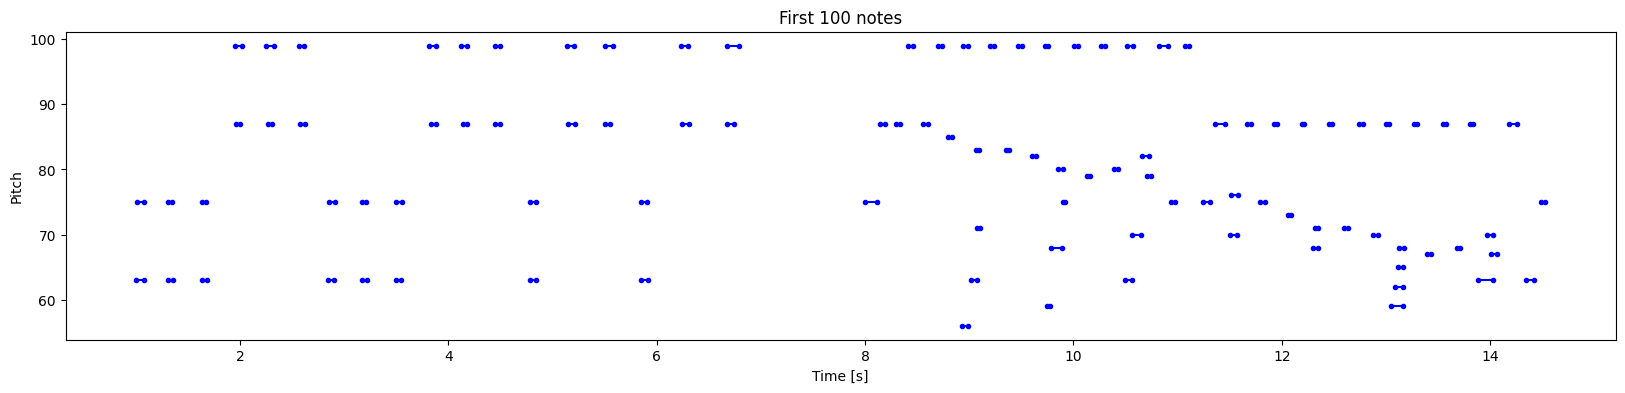

In [153]:
plot_piano_roll(raw_notes, count=100)

Plot the notes for the entire track.

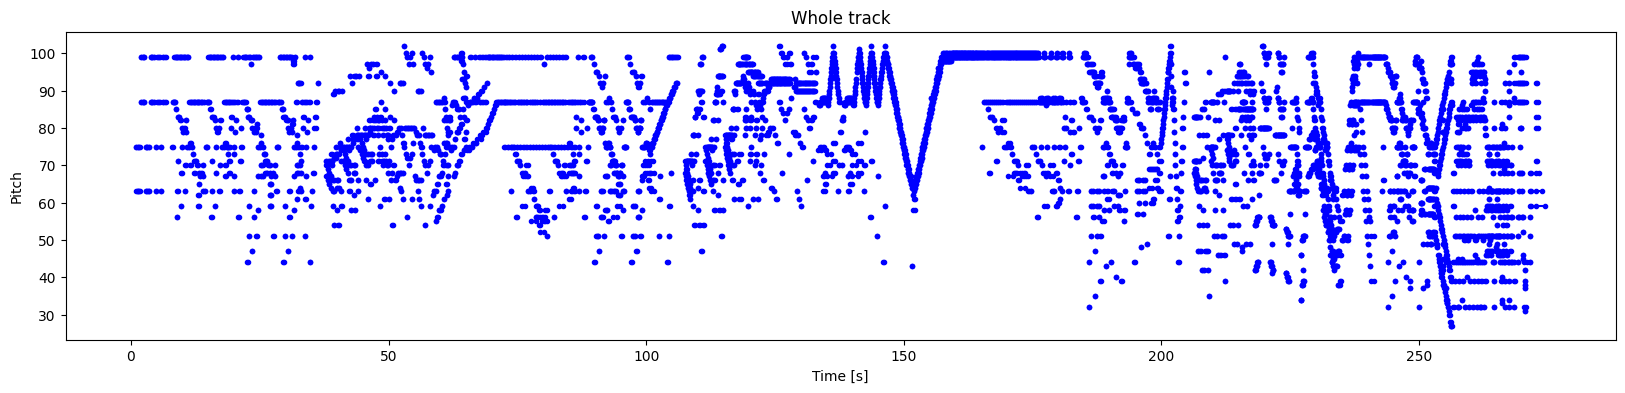

In [154]:
plot_piano_roll(raw_notes)

Check the distribution of each note variable.

In [155]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))
  
  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

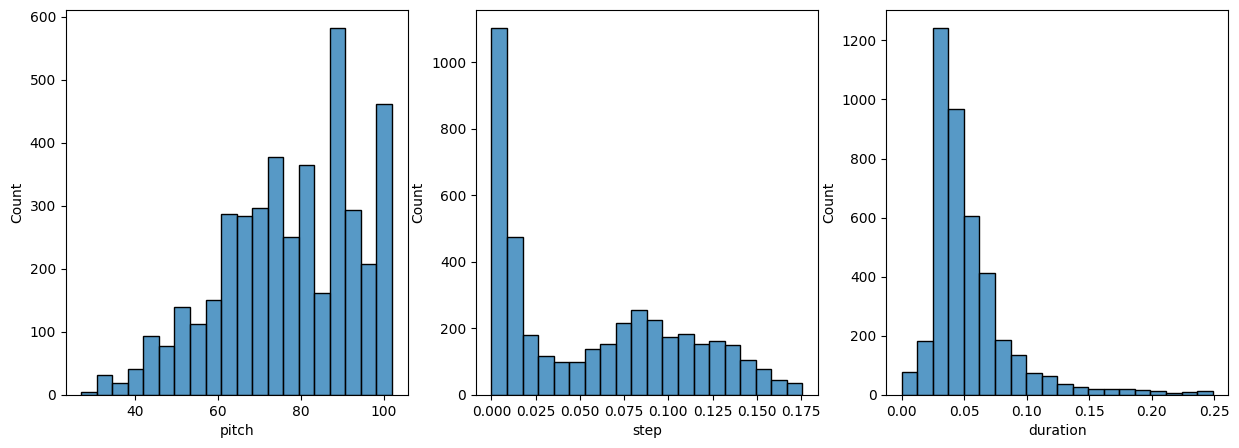

In [156]:
plot_distributions(raw_notes)

## Create a MIDI file

You can generate your own MIDI file from a list of notes using the function below.

In [157]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [158]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

Play the generated MIDI file and see if there is any difference.

In [159]:
display_audio(example_pm)

As before, you can write ```files.download(example_file)``` to download and play this file.

## Create the training dataset


Create the training dataset by extracting notes from the MIDI files. You can start by using a small number of files, and experiment later with more. This may take a couple minutes.

In [209]:
MAX_DURATION = 0.863
MAX_STEP = 0.35

In [204]:
num_files = 8
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(str(f))
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

## Plotting before clipping duration and step

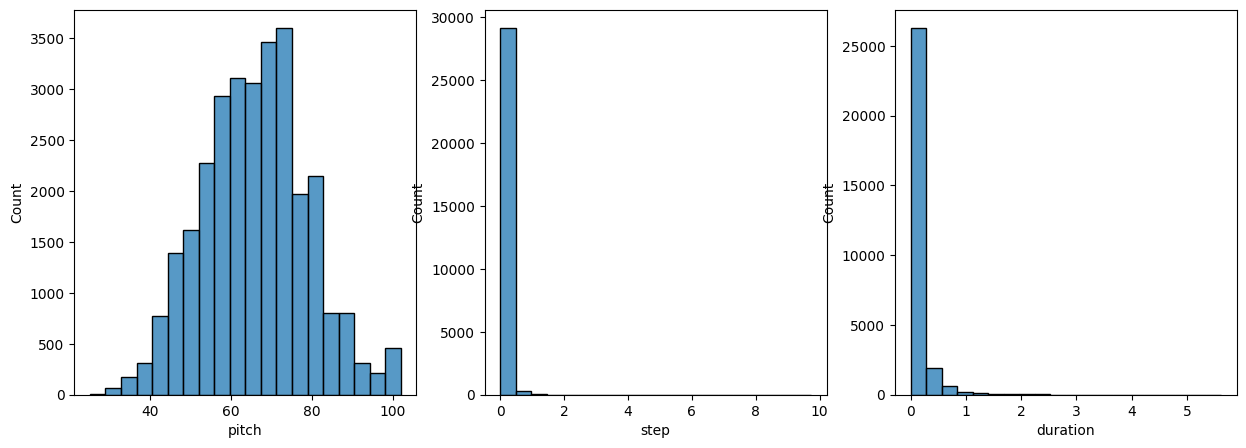

In [205]:
plot_distributions(all_notes, drop_percentile=0)

In [206]:
# 1. Compute bounds on your training set (e.g. 1st & 99th percentiles)
lower_s, upper_s = all_notes['step'].quantile([0.02, 0.98])
lower_d, upper_d = all_notes['duration'].quantile([0.02, 0.98])

mask = (
    (all_notes['step'].between(lower_s, upper_s)) &
    (all_notes['duration'].between(lower_d, upper_d))
)
all_notes = all_notes[mask].reset_index(drop=True)

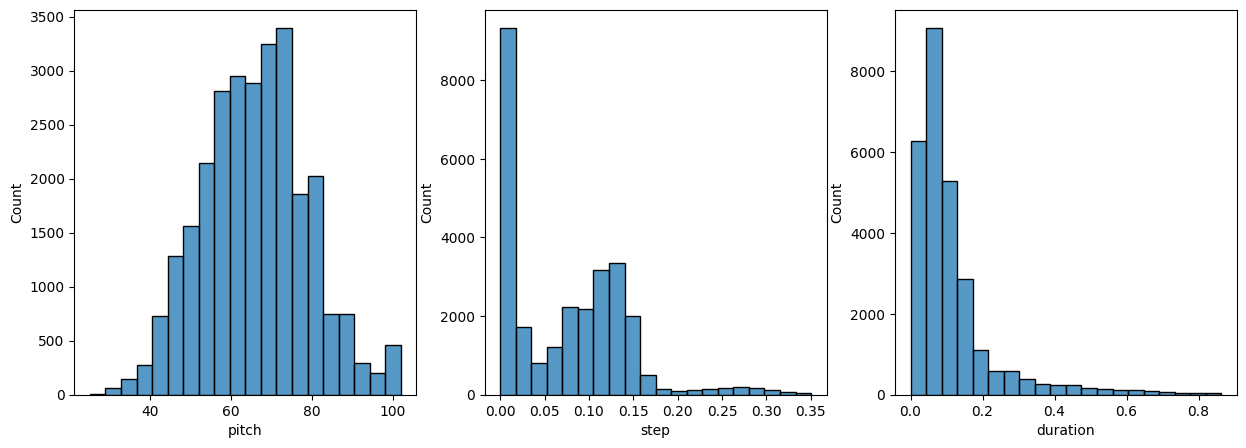

In [207]:
plot_distributions(all_notes, drop_percentile=0)

In [208]:
print(all_notes["step"].max())
print(all_notes["duration"].max())

0.3502604166666572
0.86328125


## Quantizing steps and duration

In [210]:
raw_steps = raw_notes["step"].to_numpy().astype(np.float32)
raw_durs = raw_notes["duration"].to_numpy().astype(np.float32)

In [211]:
all_steps = all_notes["step"].to_numpy().astype(np.float32)
all_durs  = all_notes["duration"].to_numpy().astype(np.float32)
N = 32
q_eps = 1e-3
def quantize(input, epsilon, num_steps):
    min_input = input.min()
    max_input = input.max()
    edges = np.geomspace(min_input + epsilon, max_input, num_steps+1)
    buckets = np.digitize(input, bins=edges) - 1
    # clamp to [0, N-1]
    buckets = np.clip(buckets, 0, N-1)
    return buckets, edges

def dequantize(buckets, edges):
    # Map each bucket back to the geometric midpoint of its interval
    lower = edges[buckets]
    upper = edges[buckets + 1]
    return np.sqrt(lower * upper)


step_buckets, step_edges = quantize(all_steps, q_eps, N)
dur_buckets, dur_edges = quantize(all_steps, q_eps, N)

all_notes["step"] = step_buckets
all_notes["duration"] = dur_buckets 

## Check that quantizing works

In [212]:
quant_step, st_edg = quantize(raw_notes["step"], q_eps, N)
quant_dur, dr_edg = quantize(raw_notes["duration"], q_eps, N)

st_dequant = dequantize(quant_step, st_edg)
dur_dequant = dequantize(quant_dur, dr_edg)

for i, note in raw_notes.iterrows():
    print(f"duration: {note['duration']}, {dur_dequant[i]}")
    print(f"step: {note['step']}, {st_dequant[i]}")

duration: 0.08647978792874504, 0.08223200735300132
step: 0.001122969193282181, 0.00235188478031879
duration: 0.07029531989676875, 0.06797512509248171
step: 0.005695313495768367, 0.005335742201876365
duration: 0.04644618022477954, 0.04644813306568267
step: 0.29378138439201246, 0.32069251355253753
duration: 0.04644618022477954, 0.04644813306568267
step: 0.001122969193282181, 0.00235188478031879
duration: 0.0377538980504208, 0.03839523996901164
step: 0.29378138439201246, 0.32069251355253753
duration: 0.04644618022477954, 0.04644813306568267
step: 0.007182130949515241, 0.006548465404769624
duration: 0.07029531989676875, 0.06797512509248171
step: 0.29378138439201246, 0.32069251355253753
duration: 0.04644618022477954, 0.04644813306568267
step: 0.009057096683845587, 0.00986345200862708
duration: 0.07029531989676875, 0.06797512509248171
step: 0.29378138439201246, 0.32069251355253753
duration: 0.0377538980504208, 0.03839523996901164
step: 0.018163354432263346, 0.01823320577449889
duration: 0.04

In [213]:
raw_notes["duration"] = dur_dequant
raw_notes["step"] = st_dequant
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

display_audio(example_pm)

In [214]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 27820


In [215]:
pitch_vocab = set(all_notes["pitch"])
vocab_size = len(pitch_vocab)
print('vocab size = ', vocab_size)

vocab size =  77


Next, create a `tf.data.Dataset` from the parsed notes.

In [216]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [217]:
train_notes.shape

(27820, 3)

In [218]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.int64, name=None)

In [219]:
len(notes_ds)

27820

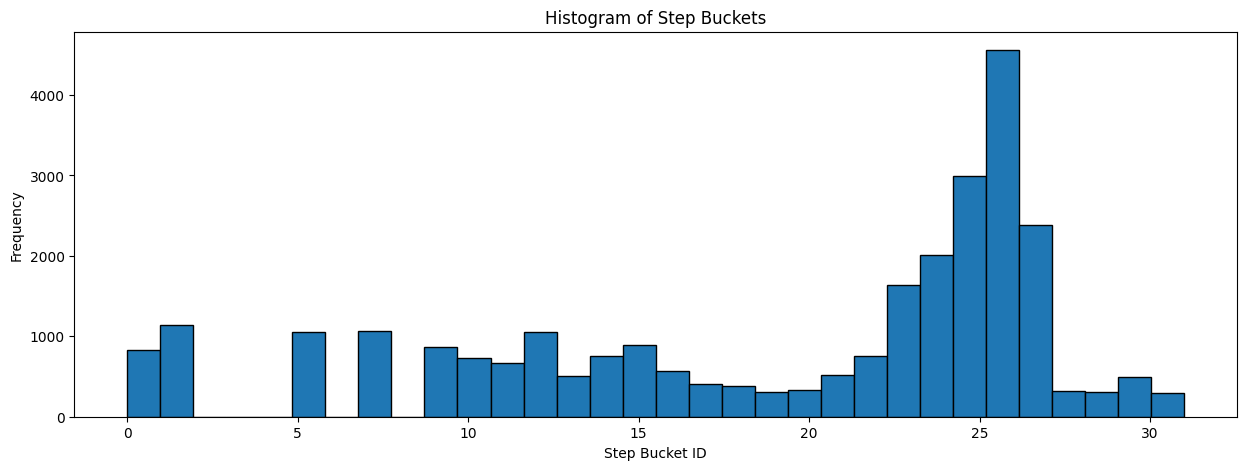

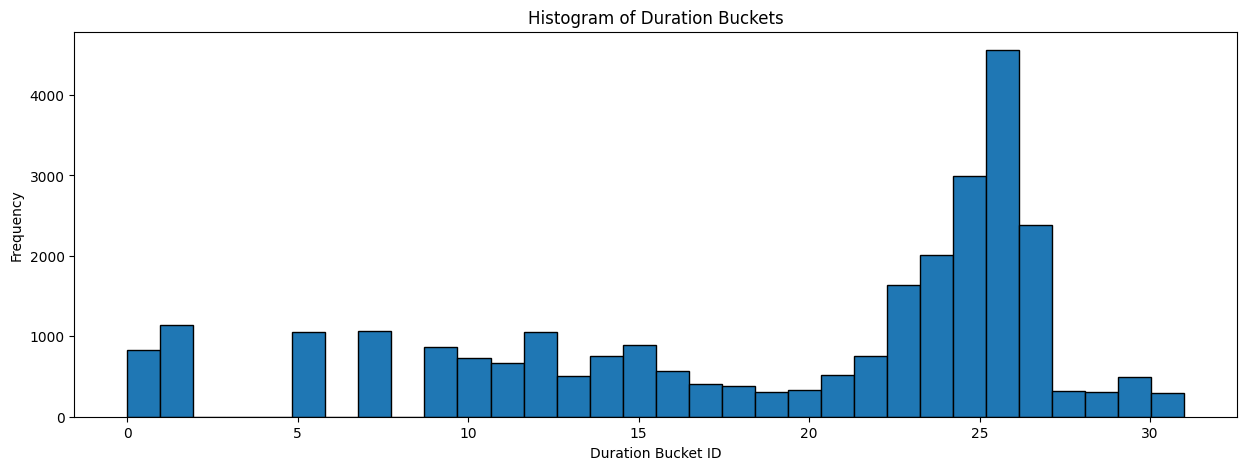

In [220]:
plt.figure(figsize=[15, 5])
plt.hist(step_buckets, bins=N, edgecolor='black')
plt.title("Histogram of Step Buckets")
plt.xlabel("Step Bucket ID")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=[15, 5])
plt.hist(dur_buckets, bins=N, edgecolor='black')
plt.title("Histogram of Duration Buckets")
plt.xlabel("Duration Bucket ID")
plt.ylabel("Frequency")
plt.show()

You will train the model on batches of sequences of notes. Each example will consist of a sequence of notes as the input features, and the next note as the label. In this way, the model will be trained to predict the next note in a sequence. You can find a diagram describing this process (and more details) in [Text classification with an RNN](https://www.tensorflow.org/text/tutorials/text_generation).

You can use the handy [window](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#window) function with size `seq_length` to create the features and labels in this format.

In [221]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size=128,
    max_step=MAX_STEP,
    max_duration=MAX_DURATION
) -> tf.data.Dataset:
    """Returns TF Dataset of ({p_in,s_in,d_in}, {pitch,step,duration}) examples."""
    # we need seq_length inputs + 1 label → window size = seq_length+1
    window_size = seq_length + 1

    # slide a window of window_size, shift=1
    windows = dataset.window(window_size,
                             shift=1,
                             stride=1,
                             drop_remainder=True)

    # each `window` is a Dataset of Tensors, so batch them
    sequences = windows.flat_map(lambda w: w.batch(window_size))

    def split_and_format(seq):
        # seq: shape = (seq_length+1, 3)
        # inputs = first seq_length rows, label = last row
        inputs = seq[:-1]            # (seq_length, 3)
        label  = seq[-1]             # (3,)

        # unpack inputs into 3 separate tensors
        pitch_seq = tf.cast(inputs[:, 0], tf.int32)
        step_seq = tf.cast(inputs[:, 1], tf.int32)
        dur_seq  = tf.cast(inputs[:, 2], tf.int32)

        # format inputs as a dict matching your Input layer names
        x = {
            'p_in': pitch_seq,
            's_in': step_seq,
            'd_in': dur_seq
        }

        # unpack the label row into targets
        y = {
            'pitch':    tf.cast(label[0], tf.int32),       # integer class
            'step':     tf.cast(label[1], tf.int32),       # float in [0,1]
            'duration': tf.cast(label[2], tf.int32),       # float in [0,1]
        }

        return x, y

    return sequences.map(split_and_format,
                         num_parallel_calls=tf.data.AUTOTUNE)


Set the sequence length for each example. Experiment with different lengths (e.g. 50, 100, 150) to see which one works best for the data, or use [hyperparameter tuning](https://www.tensorflow.org/tutorials/keras/keras_tuner). The size of the vocabulary (`vocab_size`) is set to 128 representing all the pitches supported by `pretty_midi`.

In [224]:
seq_length = 50
vocab_size = 128

## Split train-val
train_frac = 0.7
train_timesteps = int(len(notes_ds) * train_frac)
raw_train = notes_ds.take(train_timesteps)
raw_val = notes_ds.skip(train_timesteps)


train_seq = create_sequences(raw_train, seq_length, vocab_size)
val_seq = create_sequences(raw_val, seq_length, vocab_size)
train_seq.element_spec

({'p_in': TensorSpec(shape=(None,), dtype=tf.int32, name=None),
  's_in': TensorSpec(shape=(None,), dtype=tf.int32, name=None),
  'd_in': TensorSpec(shape=(None,), dtype=tf.int32, name=None)},
 {'pitch': TensorSpec(shape=(), dtype=tf.int32, name=None),
  'step': TensorSpec(shape=(), dtype=tf.int32, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.int32, name=None)})

The shape of the dataset is ```(100,1)```, meaning that the model will take 100 notes as input, and learn to predict the following note as output.

In [225]:
for seq, target in train_seq.take(1):
    print("── Inputs ─────────────────────────────────")
    print("pitch sequence shape:   ", seq['p_in'].shape)
    print("step sequence shape:    ", seq['s_in'].shape)
    print("duration sequence shape:", seq['d_in'].shape)
    print()
    print("── A few pitch values ─────────────────────")
    print(seq['p_in'][0:10].numpy())     # first 10 pitch ints
    print()
    print("── Targets ────────────────────────────────")
    print("next pitch:",    target['pitch'].numpy())
    print("next step: ",    target['step'].numpy())
    print("next duration:", target['duration'].numpy())
    break


── Inputs ─────────────────────────────────
pitch sequence shape:    (50,)
step sequence shape:     (50,)
duration sequence shape: (50,)

── A few pitch values ─────────────────────
[77 49 73 68 73 61 77 73 51 78]

── Targets ────────────────────────────────
next pitch: 75
next step:  25
next duration: 25


Batch the examples, and configure the dataset for performance.

In [226]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (train_seq
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE)
            .apply(tf.data.Dataset.ignore_errors))

val_ds = (val_seq
          .batch(batch_size, drop_remainder=True)
          .cache()
          .prefetch(tf.data.experimental.AUTOTUNE))

In [180]:
train_ds.element_spec

({'p_in': TensorSpec(shape=(64, None), dtype=tf.int32, name=None),
  's_in': TensorSpec(shape=(64, None), dtype=tf.int32, name=None),
  'd_in': TensorSpec(shape=(64, None), dtype=tf.int32, name=None)},
 {'pitch': TensorSpec(shape=(64,), dtype=tf.int32, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.int32, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.int32, name=None)})

## Create and train the model

The model will have three outputs, one for each note variable. For `step` and `duration`, you will use a custom loss function based on mean squared error that encourages the model to output non-negative values.

In [227]:
def mse(y_true: tf.Tensor, y_pred: tf.Tensor):
  sq_err = (y_true - y_pred) ** 2
  return tf.reduce_mean(sq_err)
 

In [182]:
learning_rate = 0.002
embed_dim=256

pitch_input = tf.keras.Input((seq_length,), dtype='int32', name='p_in')
step_input = tf.keras.Input((seq_length,), dtype='int32', name='s_in')
dur_input = tf.keras.Input((seq_length,), dtype='int32', name='d_in')
pitch_embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=False, name='pitch_embed')(pitch_input)
step_embed = tf.keras.layers.Embedding(input_dim=N, output_dim=embed_dim, mask_zero=False, name='step_embed')(step_input)
dur_embed = tf.keras.layers.Embedding(input_dim=N, output_dim=embed_dim, mask_zero=False, name='dur_embed')(dur_input)

x = tf.keras.layers.Concatenate(axis=-1)([pitch_embedding, step_embed, dur_embed])

x = tf.keras.layers.LSTM(512, return_sequences=True)(x)
x = tf.keras.layers.LSTM(512)(x)



# pitch stays as logits for your SparseCategoricalCrossentropy
pitch_logits = tf.keras.layers.Dense(128, name='pitch')(x)

# step and duration get a raw Dense(1) → softplus
step_raw     = tf.keras.layers.Dense(N, name="step")(x)
dur_raw      = tf.keras.layers.Dense(N, name="duration")(x)

model = tf.keras.Model({
    'p_in': pitch_input,
    's_in': step_input,
    'd_in': dur_input,
}, {
    'pitch': pitch_logits,
    'step': step_raw,
    'duration': dur_raw
})

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'duration': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True)
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)

model.compile(loss=loss, optimizer=optimizer)

model.summary() 

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ p_in (InputLayer)   │ (None, 50)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ s_in (InputLayer)   │ (None, 50)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_in (InputLayer)   │ (None, 50)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pitch_embed         │ (None, 50, 256)   │     32,768 │ p_in[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ step_embed          │ (None, 50, 256)   │      8,192 │ s_in[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dur_embed           │ (None, 50, 256)   │      8,192 │ d_in[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 50, 768)   │          0 │ pitch_embed[0][0… │
│ (Concatenate)       │                   │            │ step_embed[0][0], │
│                     │                   │            │ dur_embed[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 50, 512)   │  2,623,488 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 512)       │  2,099,200 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration (Dense)    │ (None, 32)        │     16,416 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pitch (Dense)       │ (None, 128)       │     65,664 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ step (Dense)        │ (None, 32)        │     16,416 │ lstm_3[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,870,336 (18.58 MB)

 Trainable params: 4,870,336 (18.58 MB)

 Non-trainable params: 0 (0.00 B)

In [233]:
class ScheduledSamplingModel(tf.keras.Model):
    def __init__(self,
                 vocab_size,
                 N,
                 embed_dim=256,
                 rnn_units=512,
                 seq_length=50,
                 k=1000.0,
                 loss_weights=None,
                 **kwargs):
        super().__init__(**kwargs)
        self.seq_length = seq_length
        self.k = k
        self.loss_weights = loss_weights or {
            'pitch': 1/3, 'step':1/3, 'duration':1/3
        }
        # Embedding layers
        self.pitch_embed = tf.keras.layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim, name='pitch_embed')
        self.step_embed  = tf.keras.layers.Embedding(
            input_dim=N, output_dim=embed_dim, name='step_embed')
        self.dur_embed   = tf.keras.layers.Embedding(
            input_dim=N, output_dim=embed_dim, name='dur_embed')
        # RNN cells (two layers)
        self.lstm1 = tf.keras.layers.LSTMCell(rnn_units)
        self.lstm2 = tf.keras.layers.LSTMCell(rnn_units)
        # Output heads
        self.pitch_head = tf.keras.layers.Dense(vocab_size, name='pitch')
        self.step_head  = tf.keras.layers.Dense(N, name='step')
        self.dur_head   = tf.keras.layers.Dense(N, name='duration')
        # iteration counter for ε schedule
        self.iteration = tf.Variable(0.0, trainable=False, dtype=tf.float32)

    def get_epsilon(self):
        # inverse-sigmoid decay; swap out for linear if you like
        return self.k / (self.k + tf.exp(self.iteration / self.k))

    @tf.function
    def train_step(self, data):
        # unpack your three inputs and three targets
        x_pitch, x_step, x_dur = data[0]['p_in'], data[0]['s_in'], data[0]['d_in']
        y_pitch, y_step, y_dur = data[1]['pitch'], data[1]['step'], data[1]['duration']
        batch_size = tf.shape(x_pitch)[0]

        # initial RNN states
        h1, c1 = [tf.zeros((batch_size, self.lstm1.units))]*2
        h2, c2 = [tf.zeros((batch_size, self.lstm2.units))]*2

        eps = self.get_epsilon()
        total_loss = 0.0

        with tf.GradientTape() as tape:
            # first input token at t=0
            pitch_t = x_pitch[:, 0]
            step_t  = x_step[:, 0]
            dur_t   = x_dur[:, 0]

            for t in range(1, self.seq_length):
                # embed and concat
                e_p = self.pitch_embed(pitch_t)
                e_s = self.step_embed(step_t)
                e_d = self.dur_embed(dur_t)
                x_t = tf.concat([e_p, e_s, e_d], axis=-1)  # shape (batch, 3*embed_dim)

                # run through two LSTM cells
                out1, [h1, c1] = self.lstm1(x_t, states=[h1, c1])
                out2, [h2, c2] = self.lstm2(out1, states=[h2, c2])

                # compute logits for each head
                log_p = self.pitch_head(out2)
                log_s = self.step_head(out2)
                log_d = self.dur_head(out2)

                # sample next tokens
                p_prob = tf.nn.softmax(log_p)
                s_prob = tf.nn.softmax(log_s)
                d_prob = tf.nn.softmax(log_d)
                sample_p = tf.squeeze(tf.random.categorical(tf.math.log(p_prob), 1), 1)
                sample_s = tf.squeeze(tf.random.categorical(tf.math.log(s_prob), 1), 1)
                sample_d = tf.squeeze(tf.random.categorical(tf.math.log(d_prob), 1), 1)

                # cast them to int32 to match x_pitch.dtype
                sample_p = tf.cast(sample_p, x_pitch.dtype)
                sample_s = tf.cast(sample_s, x_step.dtype)
                sample_d = tf.cast(sample_d, x_dur.dtype)

                # decide ground‐truth vs. sampled
                use_model = tf.random.uniform([batch_size], 0, 1) < eps
                pitch_t = tf.where(use_model, sample_p, x_pitch[:, t])
                step_t  = tf.where(use_model, sample_s, x_step[:, t])
                dur_t   = tf.where(use_model, sample_d, x_dur[:, t])

            # accumulate step‐wise loss
            loss_p = self.compiled_loss(y_pitch,
                log_p,
                regularization_losses=self.losses)
            loss_s = self.compiled_loss(y_step,
                log_s,
                regularization_losses=self.losses)
            loss_d = self.compiled_loss(y_dur,
                log_d,
                regularization_losses=self.losses)
            # normalize loss over time‐steps and heads
            total_loss = (
                self.loss_weights['pitch']   * loss_p +
                self.loss_weights['step']    * loss_s +
                self.loss_weights['duration']* loss_d
            )

        # backprop
        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        # update metrics
        self.compiled_metrics.update_state(y_pitch, 
                                           self.pitch_head(h2))  # example metric
        # advance ε‐counter
        self.iteration.assign_add(1.0)

        # return all metrics plus loss
        results = {m.name: m.result() for m in self.metrics}
        results.update({'loss': total_loss})
        return results

    @tf.function
    def call(self, inputs, training=False):
        # 1) Unpack inputs
        p_in, s_in, d_in = inputs['p_in'], inputs['s_in'], inputs['d_in']
        batch_size = tf.shape(p_in)[0]

         # 2) Embed all timesteps
        e_p = self.pitch_embed(p_in)   # → (batch, seq_length, embed_dim)
        e_s = self.step_embed(s_in)
        e_d = self.dur_embed(d_in)
        # 3) Concatenate and run through LSTMs
        x = tf.concat([e_p, e_s, e_d], axis=-1)      # → (batch, seq, 3*embed_dim)

        h1 = tf.zeros((batch_size, self.lstm1.units))
        c1 = tf.zeros((batch_size, self.lstm1.units))
        h2 = tf.zeros((batch_size, self.lstm2.units))
        c2 = tf.zeros((batch_size, self.lstm2.units))
        for t in range(self.seq_length):
            x_t = x[:,t,:]  # -> (batch, 3*embed_dim)
            out1, [h1, c1] = self.lstm1(x_t, states=[h1, c1], training=training)
            out2, [h2, c2] = self.lstm2(out1, states=[h2, c2], training=training)
        # 4) Compute heads
        return {
          'pitch':    self.pitch_head(out2),    # logits for SparseCategoricalCrossentropy
          'step':     self.step_head(out2),     # (you’ll apply softmax/loss later)
          'duration': self.dur_head(out2),
        }
    @tf.function
    def test_step(self, data):
        # Unpack inputs & targets
        x_pitch, x_step, x_dur = data[0]['p_in'], data[0]['s_in'], data[0]['d_in']
        y_pitch, y_step, y_dur = data[1]['pitch'], data[1]['step'], data[1]['duration']

        # Reset RNN states
        batch_size = tf.shape(x_pitch)[0]
        h1, c1 = [tf.zeros((batch_size, self.lstm1.units))]*2
        h2, c2 = [tf.zeros((batch_size, self.lstm2.units))]*2

        e_p = self.pitch_embed(x_pitch)  # ⇒ (batch, seq_len, emb_dim)
        e_s = self.step_embed(x_step)
        e_d = self.dur_embed(x_dur)
        x_seq = tf.concat([e_p, e_s, e_d], axis=-1)  
        for t in range(self.seq_length):
            x_t = x_seq[:,t,:]
            out1, [h1, c1] = self.lstm1(x_t, states=[h1, c1])
            out2, [h2, c2] = self.lstm2(out1, states=[h2,c2]) 
        # Compute logits for the **last** step (or accumulate losses each step if you prefer)
        log_p = self.pitch_head(out2)
        log_s = self.step_head(out2)
        log_d = self.dur_head(out2)

        # Compute validation loss
        loss_p = self.compiled_loss(y_pitch, log_p, regularization_losses=self.losses)
        loss_s = self.compiled_loss(y_step,  log_s, regularization_losses=self.losses)
        loss_d = self.compiled_loss(y_dur,   log_d, regularization_losses=self.losses)
        total_val_loss = (
            self.loss_weights['pitch']   * loss_p +
            self.loss_weights['step']    * loss_s +
            self.loss_weights['duration']* loss_d
        )

        # Update the metrics that were passed to compile()
        self.compiled_metrics.update_state(y_pitch, log_p)
        # …update any other metrics you care about…

        # Return a dict mapping metric names to current value
        results = {m.name: m.result() for m in self.metrics}
        results.update({'loss': total_val_loss})
        return results

# --- wiring up ---
model = ScheduledSamplingModel(
    vocab_size=vocab_size,
    N=N,
    embed_dim=embed_dim,
    rnn_units=512,
    seq_length=seq_length)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)

Testing the `model.evaluate` function, you can see that the `pitch` loss is significantly greater than the `step` and `duration` losses. 
Note that `loss` is the total loss computed by summing all the other losses and is currently dominated by the `pitch` loss.

In [239]:
losses = model.evaluate(train_ds, return_dict=True)
losses

303/303 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - loss: -2.2242 - val_loss: 3.2550


{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=-2.224867105484009>,
 'val_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2270255088806152>}

One way balance this is to use the `loss_weights` argument to compile:

In [234]:
avg = {'pitch': 4.85, 'step': 3.46, 'duration': 3.46}
inv   = { k: 1.0/v for k,v in avg.items() }
total = sum(inv.values())
weights = { k: inv[k]/total for k in inv }
print(weights)

model.loss_weights = weights

{'pitch': 0.26291793313069906, 'step': 0.36854103343465044, 'duration': 0.36854103343465044}


The `loss` then becomes the weighted sum of the individual losses.

In [235]:
model.evaluate(train_ds, return_dict=True)

/Users/adrian.carbonell/python-apps/music_rnn/music/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:671: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(
/Users/adrian.carbonell/python-apps/music_rnn/music/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:646: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


303/303 ━━━━━━━━━━━━━━━━━━━━ 27s 48ms/step - loss: 3.2883e-04 - val_loss: 3.8310


/Users/adrian.carbonell/python-apps/music_rnn/music/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.00033910831552930176>,
 'val_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8310139179229736>}

Train the model.

In [236]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}.weights.h5',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [241]:
%%time

epochs = 50

model.build(input_shape=(batch_size, seq_length, 3))

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
    303/Unknown 63s 206ms/step - loss: 3.2212

/Users/adrian.carbonell/python-apps/music_rnn/music/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


303/303 ━━━━━━━━━━━━━━━━━━━━ 69s 226ms/step - loss: 3.2017 - val_loss: -2.8344 - val_val_loss: 3.3884
Epoch 2/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 72s 237ms/step - loss: 3.1902 - val_loss: -3.0376 - val_val_loss: 3.3965
Epoch 3/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 71s 236ms/step - loss: 3.1772 - val_loss: -3.1315 - val_val_loss: 3.4599
Epoch 4/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 69s 228ms/step - loss: 3.1481 - val_loss: -3.6366 - val_val_loss: 3.5043
Epoch 5/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 70s 230ms/step - loss: 3.1223 - val_loss: -3.8460 - val_val_loss: 3.4992
Epoch 6/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 70s 229ms/step - loss: 3.1086 - val_loss: -3.9498 - val_val_loss: 3.5484
Epoch 7/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 70s 232ms/step - loss: 3.0966 - val_loss: -3.9801 - val_val_loss: 3.5366
Epoch 8/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 69s 227ms/step - loss: 3.0876 - val_loss: -4.0835 - val_val_loss: 3.5159
Epoch 9/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 69s 228ms/step - loss: 3.0814 - val_loss: -4.1605 - val_val_loss: 3

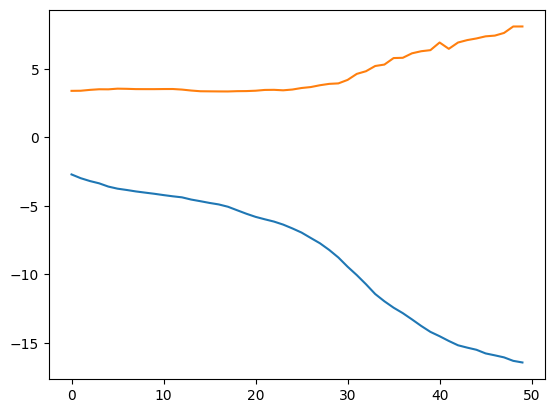

In [243]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.plot(history.epoch, history.history['val_val_loss'], label='total loss')

plt.show()

## Generate notes

To use the model to generate notes, you will first need to provide a starting sequence of notes. The function below generates one note from a sequence of notes. 

For note pitch, it draws a sample from the softmax distribution of notes produced by the model, and does not simply pick the note with the highest probability.
Always picking the note with the highest probability would lead to repetitive sequences of notes being generated.

The `temperature` parameter can be used to control the randomness of notes generated. You can find more details on temperature in [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation).

In [190]:
def predict_next_note(
    notes: np.ndarray, 
    model: tf.keras.Model, 
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # 1) Unpack and cast the incoming notes array
  # ------------------------------------------------
  # notes[:, 0] are pitches (ints)
  # notes[:, 1] are steps (floats)
  # notes[:, 2] are durations (floats)
  seq_length = notes.shape[0]

  pitch_seq = notes[:, 0].astype('int32')             # (seq_length,)
  step_seq  = notes[:, 1].astype('int32')           # (seq_length,)
  dur_seq   = notes[:, 2].astype('int32')           # (seq_length,)

  # 2) Add the “batch” and “feature” dims as needed
  # ------------------------------------------------
  # pitch input is (batch, seq_length)
  p_in = np.expand_dims(pitch_seq, axis=0)            # (1, seq_length)

  # step/dur inputs are (batch, seq_length, 1)
  s_in = np.expand_dims(step_seq, axis=0)        # (1, seq_length)
  d_in = np.expand_dims(dur_seq,  axis=0)        # (1, seq_length)

  # 3) Predict
  # ------------------------------------------------
  predictions = model.predict({
      'p_in': p_in,
      's_in': s_in,
      'd_in': d_in
  }, verbose=0)
  pitch_logits = predictions['pitch']
  step_logits = predictions['step']
  duration_logits = predictions['duration']
 
  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  quantized_step = tf.random.categorical(step_logits, num_samples=1)
  quantized_duration = tf.random.categorical(duration_logits, num_samples=1)


  pitch = tf.squeeze(pitch, axis=-1)
  quantized_duration = tf.squeeze(quantized_duration, axis=-1)
  quantized_step = tf.squeeze(quantized_step, axis=-1)
  print(f"quantized_dur {quantized_duration} quantized_step {quantized_step}")

  duration = dequantize(np.array(quantized_duration), dur_edges)
  step = dequantize(np.array(quantized_step), step_edges)

  print(f"duration {duration} step {step}")
  
  return int(pitch), float(step), float(duration)

Now generate some notes. You can play around with temperature and the starting sequence in `next_notes` and see what happens.

In [191]:
temperature = 1
num_predictions = 120

sample_notes = np.stack([all_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = sample_notes[:seq_length]

df_notes = pd.DataFrame(
    all_notes[:seq_length], columns=(*key_order, 'start', 'end'))

df_notes["step"] = dequantize(df_notes["step"], step_edges)
df_notes["duration"] = dequantize(df_notes["duration"], dur_edges)

md_file = notes_to_midi(df_notes, out_file='output.mid', instrument_name=instrument_name)
display_audio(md_file)

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

quantized_dur [25] quantized_step [25]
duration [0.09567479] step [0.09567479]
quantized_dur [26] quantized_step [26]
duration [0.11441312] step [0.11441312]
quantized_dur [25] quantized_step [26]
duration [0.09567479] step [0.11441312]


/var/folders/jq/1548k65911v7963jkjv_ls4w0000gr/T/ipykernel_6167/1211526438.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(pitch), float(step), float(duration)


quantized_dur [7] quantized_step [7]
duration [0.00382461] step [0.00382461]
quantized_dur [25] quantized_step [25]
duration [0.09567479] step [0.09567479]
quantized_dur [7] quantized_step [1]
duration [0.00382461] step [0.00130773]
quantized_dur [7] quantized_step [7]
duration [0.00382461] step [0.00382461]
quantized_dur [25] quantized_step [26]
duration [0.09567479] step [0.11441312]
quantized_dur [7] quantized_step [7]
duration [0.00382461] step [0.00382461]
quantized_dur [26] quantized_step [26]
duration [0.11441312] step [0.11441312]
quantized_dur [26] quantized_step [7]
duration [0.11441312] step [0.00382461]
quantized_dur [24] quantized_step [25]
duration [0.08000537] step [0.09567479]
quantized_dur [7] quantized_step [7]
duration [0.00382461] step [0.00382461]
quantized_dur [10] quantized_step [16]
duration [0.00654067] step [0.01912901]
quantized_dur [7] quantized_step [26]
duration [0.00382461] step [0.11441312]
quantized_dur [7] quantized_step [7]
duration [0.00382461] step 

In [192]:
generated_notes.head(50)

pitch      step  duration     start       end
0      73  0.095675  0.095675  0.095675  0.191350
1      56  0.114413  0.114413  0.210088  0.324501
2      77  0.114413  0.095675  0.324501  0.420176
3      78  0.003825  0.003825  0.328326  0.332150
4      78  0.095675  0.095675  0.424000  0.519675
5      78  0.001308  0.003825  0.425308  0.429133
6      62  0.003825  0.003825  0.429133  0.432957
7      78  0.114413  0.095675  0.543546  0.639221
8      65  0.003825  0.003825  0.547370  0.551195
9      60  0.114413  0.114413  0.661784  0.776197
10     78  0.003825  0.114413  0.665608  0.780021
11     78  0.095675  0.080005  0.761283  0.841288
12     77  0.003825  0.003825  0.765108  0.768932
13     78  0.019129  0.006541  0.784237  0.790777
14     78  0.114413  0.003825  0.898650  0.902474
15     80  0.003825  0.003825  0.902474  0.906299
16     78  0.003825  0.095675  0.906299  1.001974
17     77  0.003825  0.136821  0.910124  1.046945
18     78  0.003825  0.003825  0.913948  0.917773
19     62  0.003825  0.003825  0.917773  0.921597
20     78  0.003825  0.114413  0.921597  1.036011
21     78  0.006541  0.003825  0.928138  0.931963
22     78  0.114413  0.095675  1.042551  1.138226
23     80  0.003825  0.003825  1.046376  1.050200
24     78  0.003825  0.003825  1.050200  1.054025
25     77  0.003825  0.095675  1.054025  1.149700
26     78  0.003825  0.080005  1.057850  1.137855
27     62  0.003825  0.114413  1.061674  1.176087
28     78  0.114413  0.080005  1.176087  1.256093
29     78  0.003825  0.003825  1.179912  1.183737
30     78  0.003825  0.003825  1.183737  1.187561
31     78  0.003825  0.003825  1.187561  1.191386
32     62  0.006541  0.006541  1.194102  1.200643
33     78  0.003825  0.003825  1.197927  1.201751
34     77  0.003825  0.003825  1.201751  1.205576
35     78  0.003825  0.114413  1.205576  1.319989
36     62  0.003825  0.003825  1.209400  1.213225
37     60  0.114413  0.114413  1.323814  1.438227
38     78  0.032714  0.032714  1.356527  1.389241
39     77  0.095675  0.080005  1.452202  1.532207
40     62  0.003825  0.003825  1.456026  1.459851
41     77  0.114413  0.114413  1.570440  1.684853
42     82  0.080005  0.080005  1.650445  1.730450
43     58  0.003825  0.003825  1.654270  1.658094
44     62  0.114413  0.002674  1.768683  1.771357
45     78  0.003825  0.114413  1.772507  1.886920
46     78  0.006541  0.003825  1.779048  1.782873
47     80  0.003825  0.003825  1.782873  1.786697
48     62  0.095675  0.095675  1.878547  1.974222
49     78  0.019129  0.019129  1.897676  1.916805

In [193]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

In [194]:
full_melody = pd.concat([df_notes, generated_notes])
out_pm = notes_to_midi(
    full_melody, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)


You can also download the audio file by adding the two lines below:

```
from google.colab import files
files.download(out_file)
```

Visualize the generated notes.

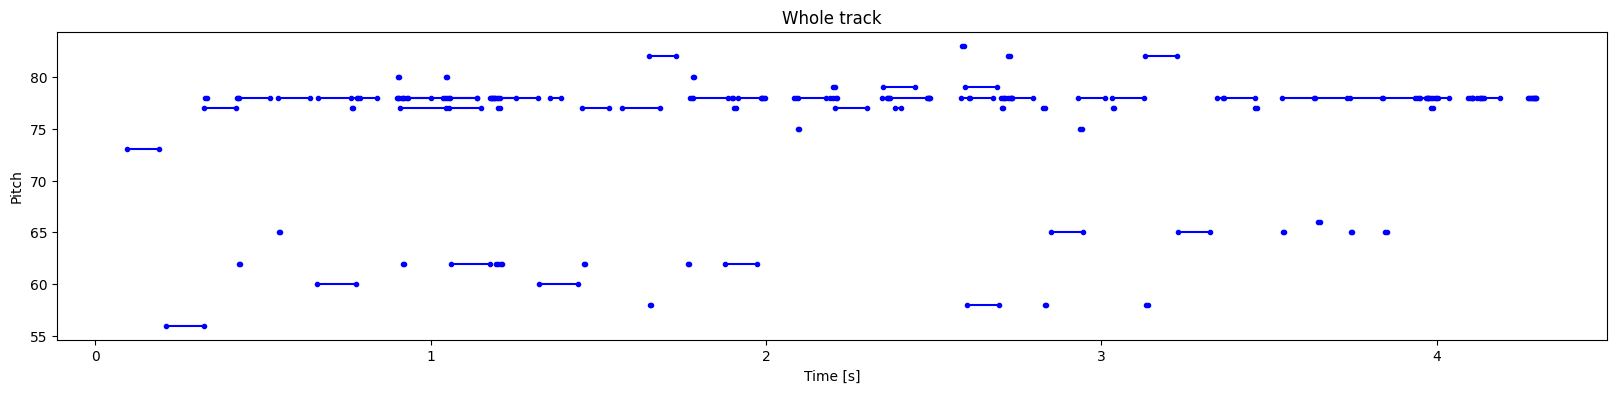

In [195]:
plot_piano_roll(generated_notes)

Check the distributions of `pitch`, `step` and `duration`.

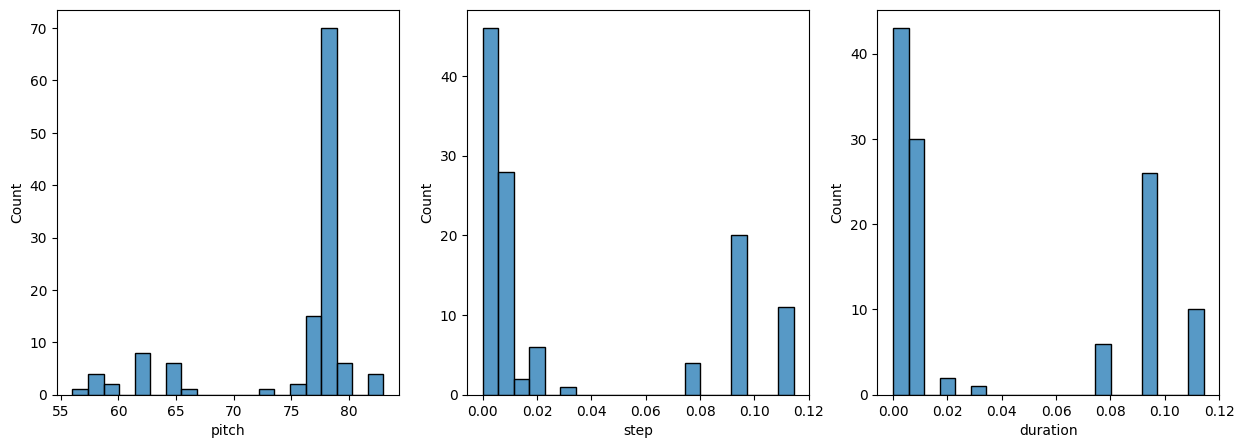

In [196]:
plot_distributions(generated_notes)

In the above plots, you will notice the change in distribution of the note variables.
Since there is a feedback loop between the model's outputs and inputs, the model tends to generate similar sequences of outputs to reduce the loss. 
This is particularly relevant for `step` and `duration`, which uses the MSE loss.
For `pitch`, you can increase the randomness by increasing the `temperature` in `predict_next_note`.


## Next steps

This tutorial demonstrated the mechanics of using an RNN to generate sequences of notes from a dataset of MIDI files. To learn more, you can visit the closely related [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation) tutorial, which contains additional diagrams and explanations. 

One of the alternatives to using RNNs for music generation is using GANs. Rather than generating audio, a GAN-based approach can generate an entire sequence in parallel. The Magenta team has done impressive work on this approach with [GANSynth](https://magenta.tensorflow.org/gansynth). You can also find many wonderful music and art projects and open-source code on [Magenta project website](https://magenta.tensorflow.org/).